In [1]:
import pandas as pd
import numpy as np

experiments = dict(
    standard='standard',
    p10='p = 1',
    p8='p = 0.8',
    p6='p = 0.6',
    p4='p = 0.4',
    p2='p = 0.2',
    p0='p = 0',
)
seeds = [f's{i}' for i in range(1, 11)]
stats = {}
tests = []
fits = []

base_dir = '../../datalake/ppsn'

for experiment, proportion in experiments.items():
    stats_data = f'{base_dir}/{experiment}/data/xdpole/runstats'
    stats[experiment] = {}
    for seed in seeds:
        seed_stats = pd.read_csv(f'{stats_data}/{seed}_run.csv')
        gens = seed_stats.gen.max()
        seed_test = pd.read_csv(f'{stats_data}/{seed}_test.csv')
        tests.append(dict(
            seed=seed,
            experiment=proportion,
            score=seed_test.score[0],
            generations=gens
        ))
        fits.append(dict(
            seed=seed,
            experiment=proportion,
            generations=gens,
            bestgfit=seed_stats.bestgfit.max()
        ))
        stats[experiment][seed] = seed_stats

Text(0.5, 0, '')

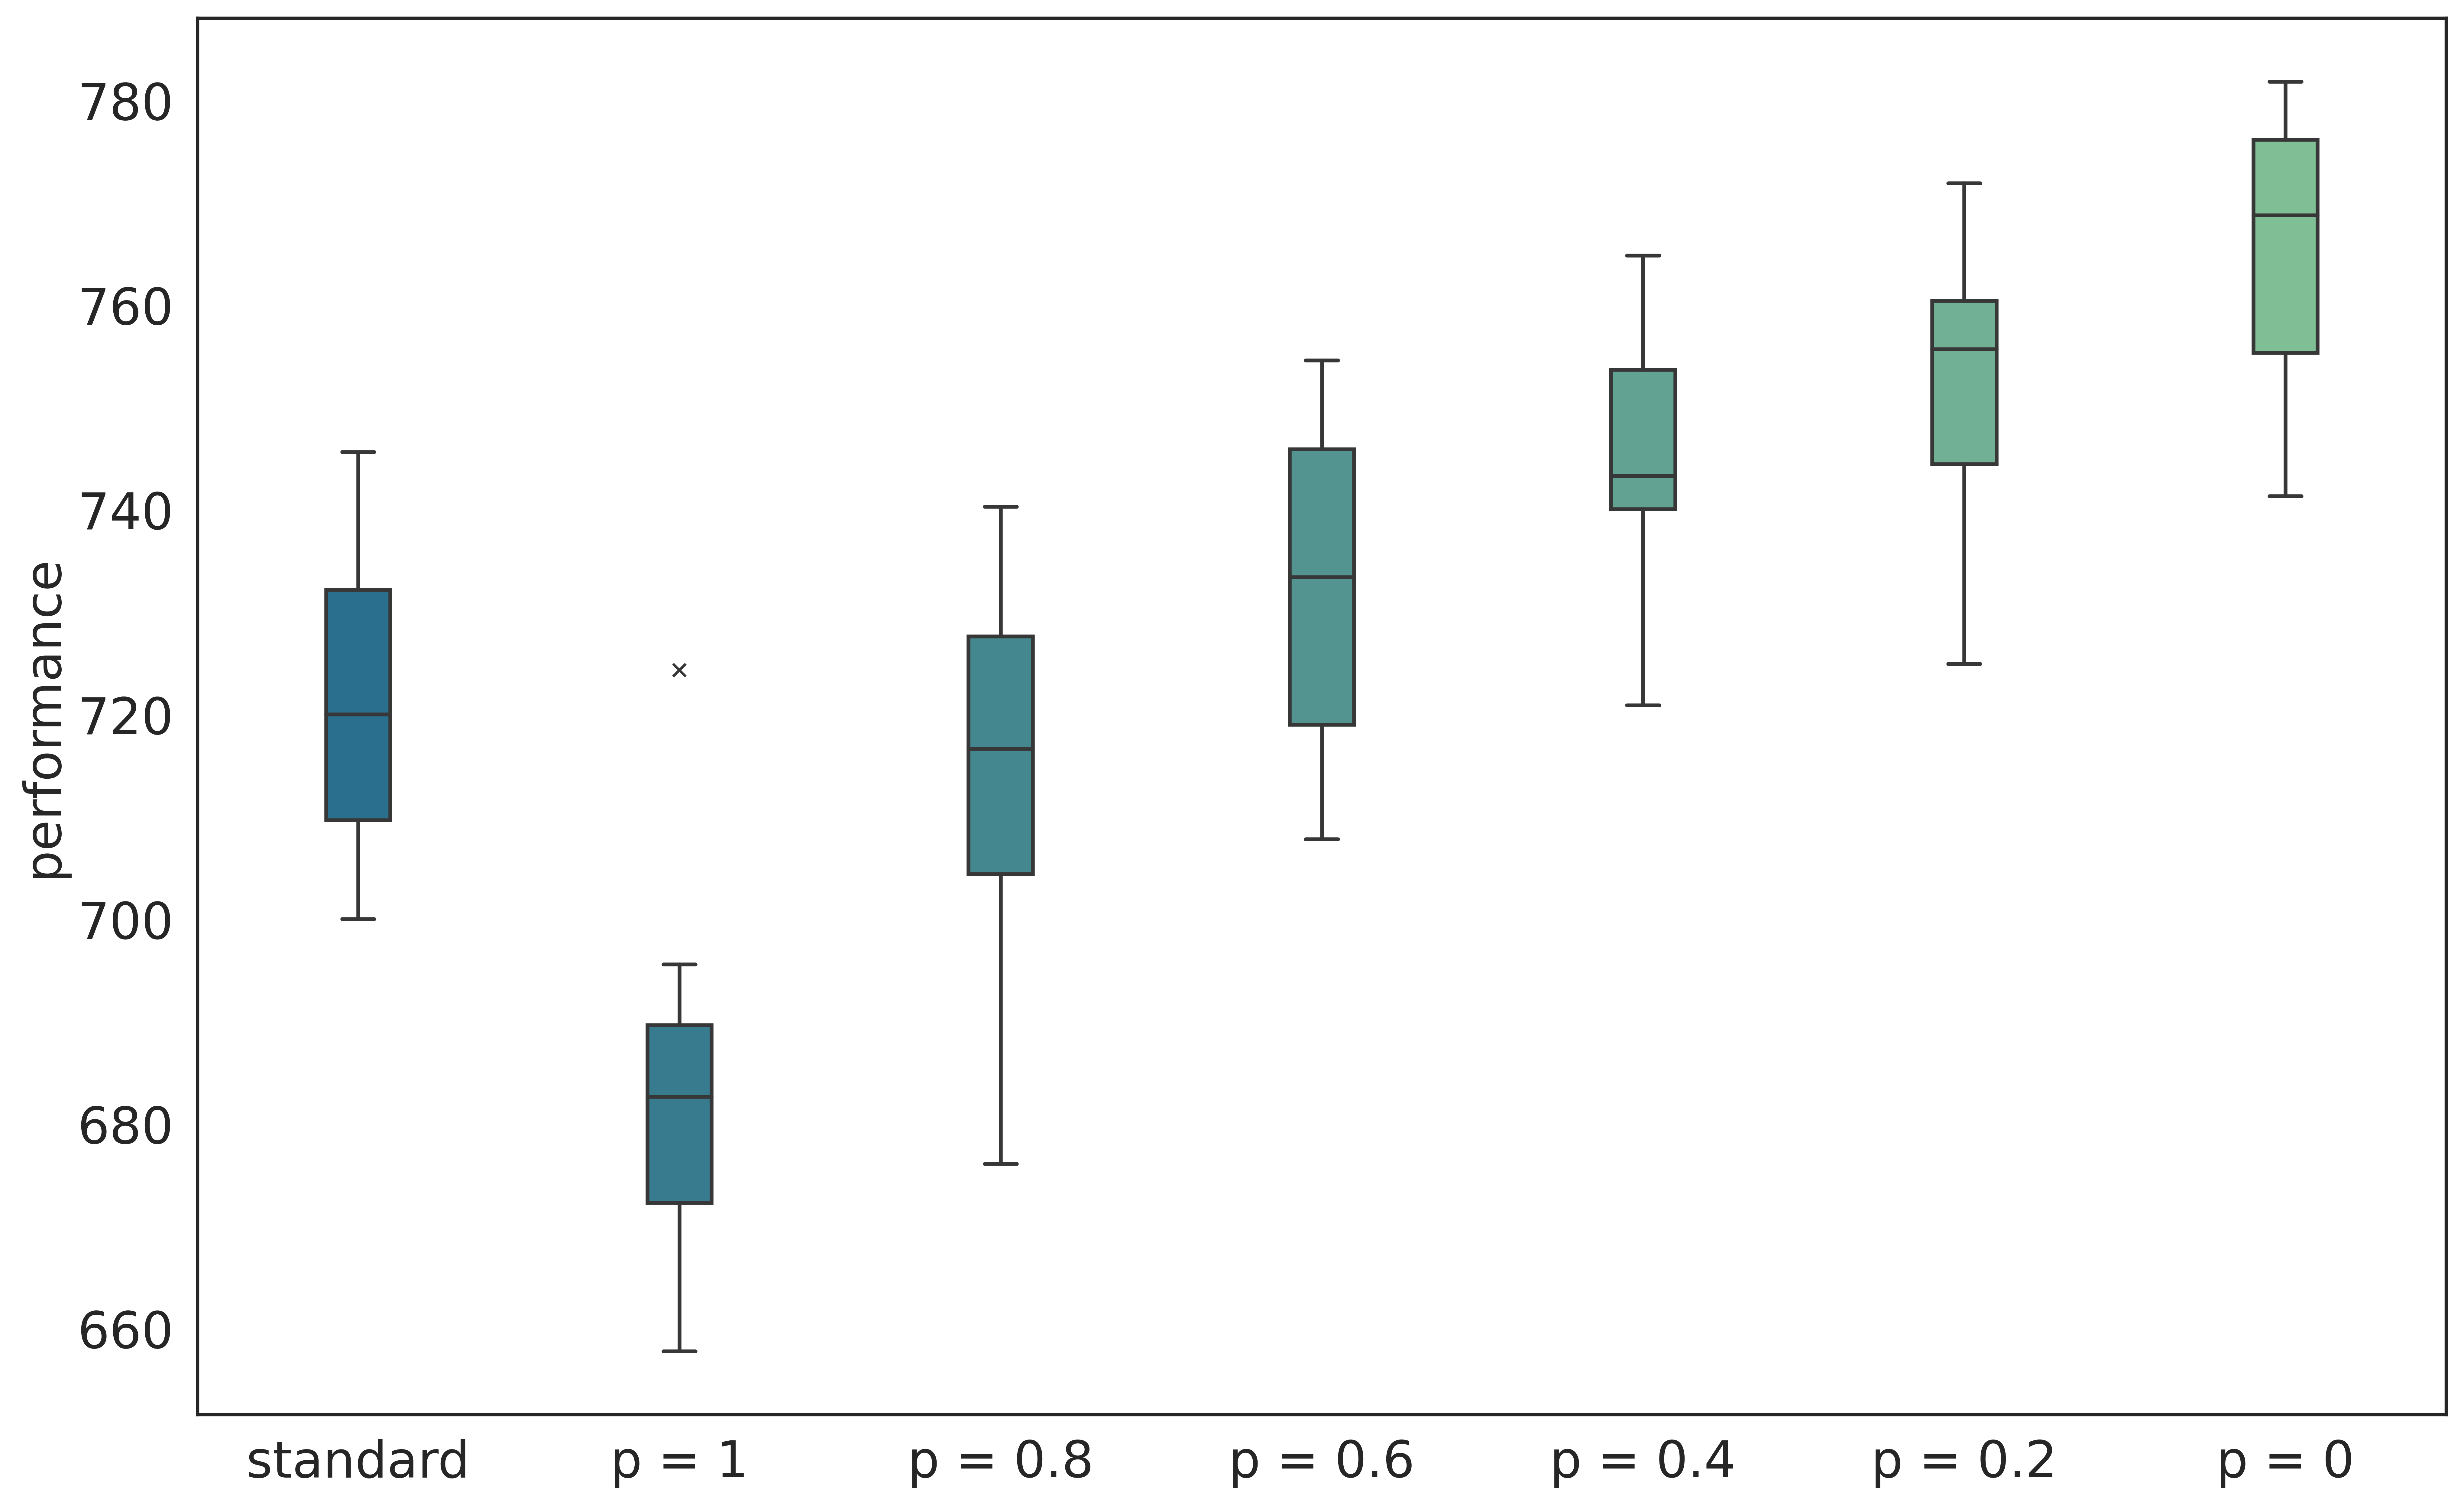

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set(rc={'figure.figsize':(16,10)}, style='white')

palette = 'blend:#1a759f,#76c893'
df = pd.DataFrame(tests)
plt.figure(dpi=600)
sns.boxplot(df, x='experiment', y='score', width=0.2, flierprops={"marker": "x"}, palette=palette)
plt.ylabel("performance", fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel("")

Text(0.5, 0, '')

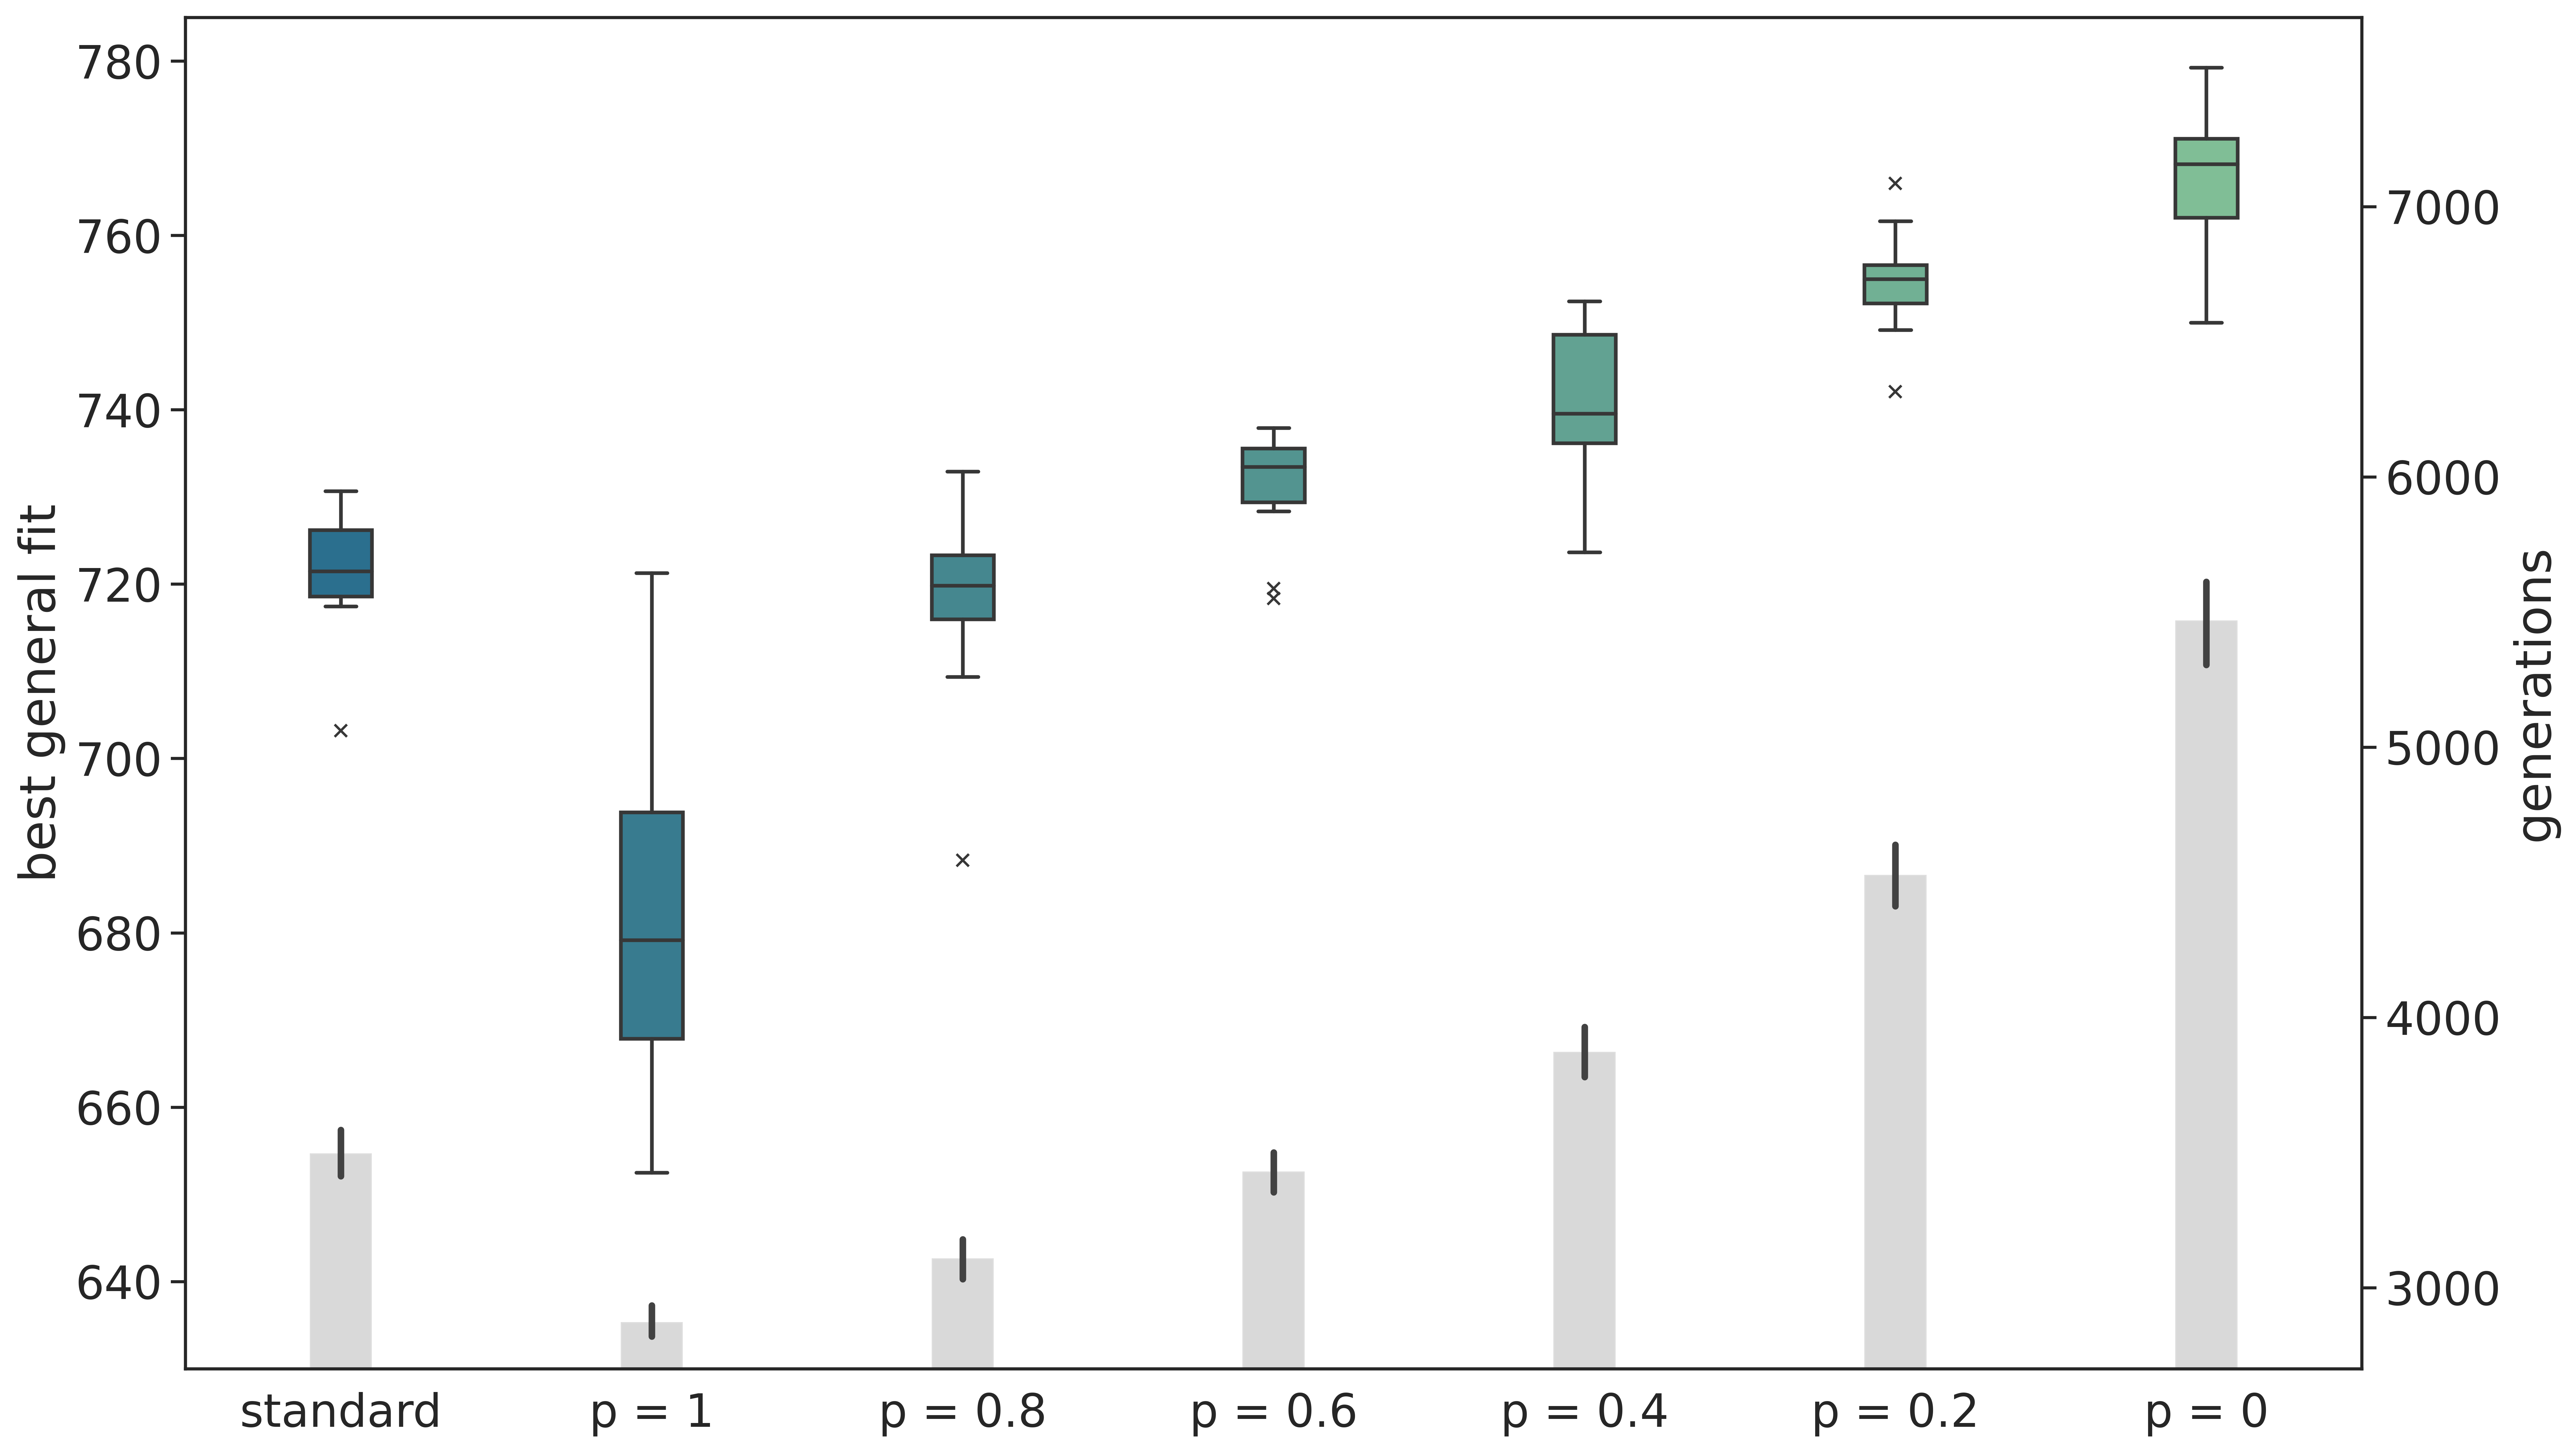

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set(rc={'figure.figsize':(16,10)}, font_scale=1.7, style='white')

palette = 'blend:#1a759f,#76c893'
df = pd.DataFrame(fits)
plt.figure(dpi=600)
ax = sns.boxplot(
    df,
    x='experiment',
    y='bestgfit',
    width=0.2,
    flierprops={"marker": "x"},
    palette=palette
)
ax2 = ax.twinx()
ax2 = sns.barplot(data=df,
    y='generations',
    x='experiment',
    width=0.2,
    color='black',
    alpha=0.15
)
ax.set_ylabel("best general fit")
ax.set_ylim([630, 785])
ax2.set_ylabel("generations")
ax2.set_ylim([2700, 7700])
ax.set_xlabel("")

In [7]:
mean_stats = pd.DataFrame()

maxmsteps = 10000
palette = 'blend:#1a759f,#76c893'

comparison = dict(
    standard='standard',
    p0='p = 0'
)

for experiment, proportion in comparison.items():
    experiment_stats = stats[experiment]

    seeds_df = pd.DataFrame()
    for seed in seeds:
        seed_df = experiment_stats[seed]
        df = pd.DataFrame()
        df['progress'] = [i/maxmsteps for i in range(maxmsteps)]
        
        bestgfits = seed_df.bestgfit.unique()
        mmsteps = []
        for bestgfit in bestgfits:
            msteps = seed_df[seed_df["bestgfit"] == bestgfit].msteps.max()
            mmsteps.append(msteps)

        performance = []
        idx = 0
        bgf = bestgfits[idx]
        for i in range(maxmsteps):
            if i > mmsteps[idx]:
                idx += 1
                bgf = bestgfits[idx]
            performance.append(bgf)

        df['performance'] = performance
        df['seed'] = seed

        seeds_df = pd.concat([seeds_df, df], ignore_index=True) if not seeds_df.empty else df

    seeds_df['experiment'] = proportion
    mean_stats = pd.concat([mean_stats, seeds_df], ignore_index=True) if not mean_stats.empty else seeds_df

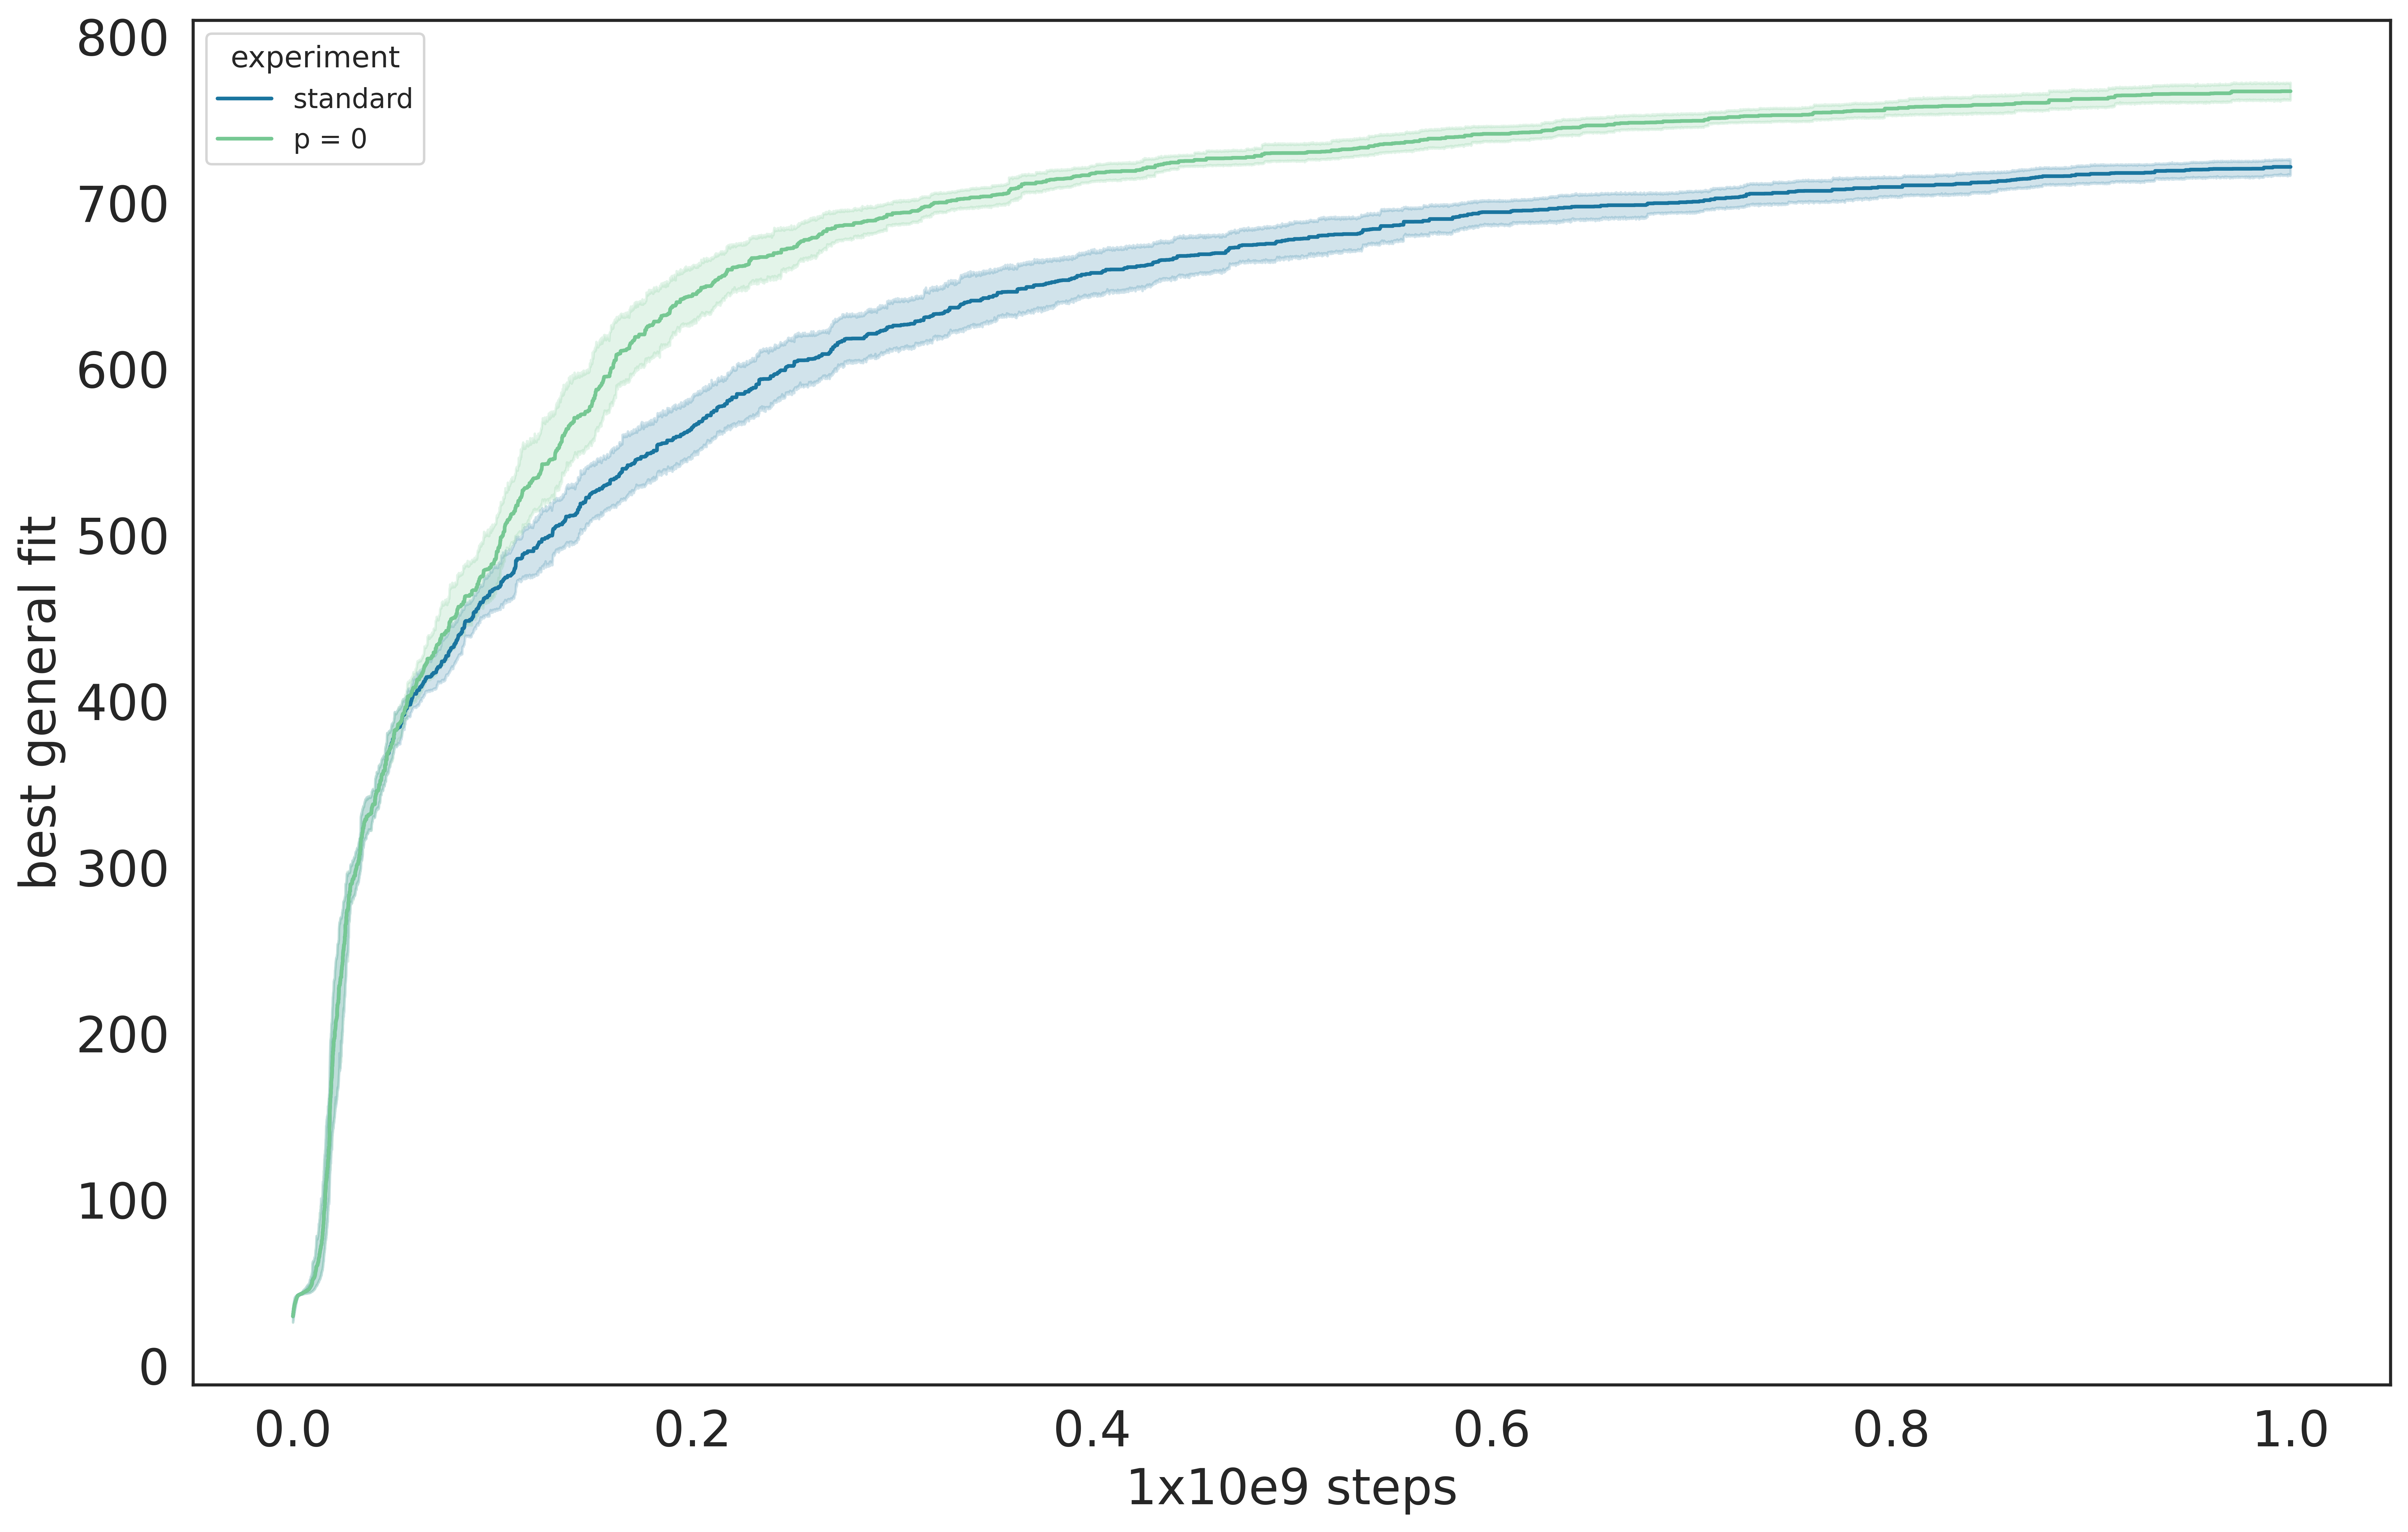

In [8]:
plt.figure(dpi=600)
sns.lineplot(
    mean_stats,
    x='progress',
    y='performance',
    hue='experiment',
    palette=palette,
    estimator="mean"
)
plt.ylabel("best general fit", fontsize=20)
plt.xlabel("1x10e9 steps", fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.show()